In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import time
import os
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
X=np.load('./npy_rice64/x_train.npy')
Y=np.load('./npy_rice64/y_train.npy')

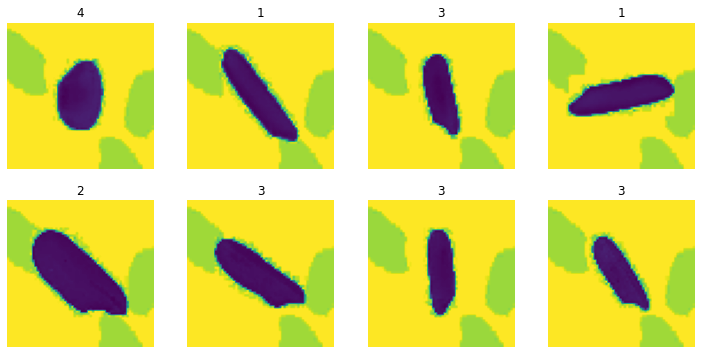

In [3]:
plt.figure(figsize=(10,10))
for i in range(0, 8):
    plt.subplot(440 + 1 + i)
    plt.tight_layout()
    plt.imshow(X[i*100], cmap=plt.get_cmap())
    plt.axis('off')
    plt.title(Y[i*100].argmax())    
plt.show()

In [4]:
X.shape

(45000, 64, 64)

In [5]:
Y.shape

(45000, 5)

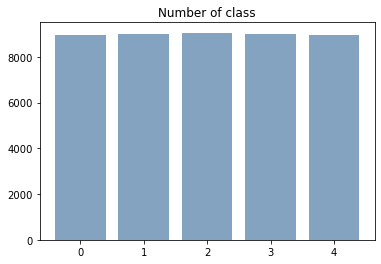

In [6]:
num_class = np.unique(Y.argmax(axis=1), return_counts=True) 
plt.title("Number of class")
plt.xticks(num_class[0])
plt.bar(num_class[0], num_class[1],color = (0.2, 0.4, 0.6, 0.6) )
plt.show()

In [7]:
X_flat = np.array(X).reshape((-1, 64*64))
X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.4, random_state=42)

In [8]:
X_flat.shape

(45000, 4096)

In [9]:
#Principle Componenet Analysis (PCA)

In [10]:
from sklearn.decomposition import PCA
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.87) + 1
d

49

In [11]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (45000, 49)
recovered shape: (45000, 4096)


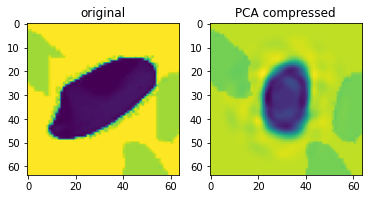

In [13]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

In [14]:
X = X.reshape(-1, 64, 64, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=20)

In [15]:
X_train.shape

(36000, 64, 64, 1)

In [16]:
y_train.shape

(36000, 5)

In [17]:
# Convert Images to Gray scale

In [18]:
X_train = X_train /255
X_test = X_test/255

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Convolution2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Create Model

In [20]:
import keras
from keras import layers,models
from keras.layers import BatchNormalization

from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

In [21]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [22]:
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(68, (5, 5), input_shape = (64, 64, 1), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(68, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


classifier.add(Conv2D(68, (5, 5), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
#classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dropout(0.5))

classifier.add(Flatten())
classifier.add(BatchNormalization())
classifier.add(Dense(units = 5, activation = 'softmax'))

# Compiling the CNN

classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [23]:
from keras.preprocessing.image import ImageDataGenerator

# Generate Images
train_datagen = ImageDataGenerator(
                                   shear_range = 0.08,
                                   zoom_range = 0.08,
                                   horizontal_flip = False,
                                   width_shift_range= 0.02,
                                   height_shift_range= 0.02)
test_datagen = ImageDataGenerator(rescale = 1./255)

# fit parameters from data
training_set = train_datagen.flow(X_train, y_train, batch_size=10)
test_set = test_datagen.flow(X_test, y_test, batch_size=10)

start = time.time() # Measuring the processing time
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 50,
                         epochs =100,
                         validation_data = test_set,
                         validation_steps = 10,
                         verbose=2)
end = time.time()
print(end - start)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
50/50 - 5s - loss: 1.6068 - accuracy: 0.2040 - val_loss: 1.6119 - val_accuracy: 0.1500
Epoch 2/100
50/50 - 4s - loss: 1.5918 - accuracy: 0.2960 - val_loss: 1.6094 - val_accuracy: 0.2400
Epoch 3/100
50/50 - 4s - loss: 1.4825 - accuracy: 0.3880 - val_loss: 1.6077 - val_accuracy: 0.2300
Epoch 4/100
50/50 - 4s - loss: 1.1831 - accuracy: 0.4700 - val_loss: 1.6614 - val_accuracy: 0.1900
Epoch 5/100
50/50 - 4s - loss: 1.0722 - accuracy: 0.5300 - val_loss: 1.7511 - val_accuracy: 0.2100
Epoch 6/100
50/50 - 4s - loss: 0.9358 - accuracy: 0.5860 - val_loss: 1.9880 - val_accuracy: 0.2900
Epoch 7/100
50/50 - 4s - loss: 0.8667 - accuracy: 0.6160 - val_loss: 2.6863 - val_accuracy: 0.2500
Epoch 8/100
50/50 - 4s - loss: 0.8473 - accuracy: 0.6400 - val_loss: 3.7130 - val_accuracy: 0.2300
Epoch 9/100
50/50 - 4s - loss: 0.7357 - accuracy: 0.6580 - val_loss: 5.4266 - val_accuracy: 0.2400
Epoch 10/100
50/50 - 4s - loss: 0

Epoch 80/100
50/50 - 4s - loss: 0.3564 - accuracy: 0.8560 - val_loss: 28.2592 - val_accuracy: 0.2000
Epoch 81/100
50/50 - 4s - loss: 0.4192 - accuracy: 0.8340 - val_loss: 29.3939 - val_accuracy: 0.1900
Epoch 82/100
50/50 - 4s - loss: 0.3721 - accuracy: 0.8480 - val_loss: 28.4990 - val_accuracy: 0.2500
Epoch 83/100
50/50 - 4s - loss: 0.4102 - accuracy: 0.8300 - val_loss: 27.8828 - val_accuracy: 0.2900
Epoch 84/100
50/50 - 4s - loss: 0.3405 - accuracy: 0.8880 - val_loss: 28.0288 - val_accuracy: 0.1900
Epoch 85/100
50/50 - 4s - loss: 0.3023 - accuracy: 0.8680 - val_loss: 31.1933 - val_accuracy: 0.1500
Epoch 86/100
50/50 - 4s - loss: 0.4106 - accuracy: 0.8380 - val_loss: 30.7077 - val_accuracy: 0.1500
Epoch 87/100
50/50 - 4s - loss: 0.3473 - accuracy: 0.8760 - val_loss: 27.6615 - val_accuracy: 0.2000
Epoch 88/100
50/50 - 4s - loss: 0.3371 - accuracy: 0.8640 - val_loss: 26.5520 - val_accuracy: 0.2100
Epoch 89/100
50/50 - 4s - loss: 0.4223 - accuracy: 0.8320 - val_loss: 22.3274 - val_accurac

In [24]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 68)        1768      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 68)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 68)        115668    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 68)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 68)          115668    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 68)          0         
_________________________________________________________________
dense (Dense)                (None, 4, 4, 256)         1

In [25]:
scores = classifier.evaluate(X_test, y_test, verbose=1)
print("{}: {:.2f}%".format(classifier.metrics_names[1], scores[1]*100))

282/282 [==============================] - 16s 56ms/step - loss: 0.1395 - accuracy: 0.9569
accuracy: 95.69%


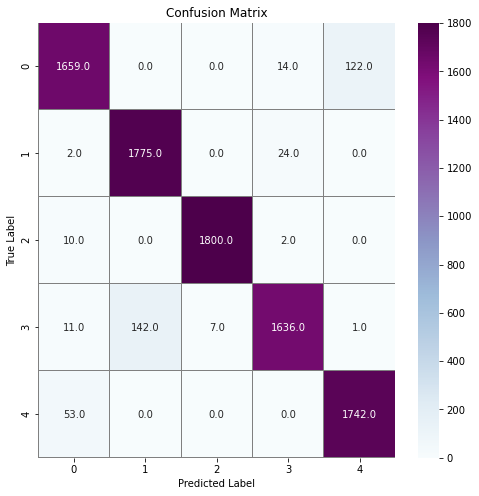

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 
# Predict the values from the validation dataset
Y_pred = classifier.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



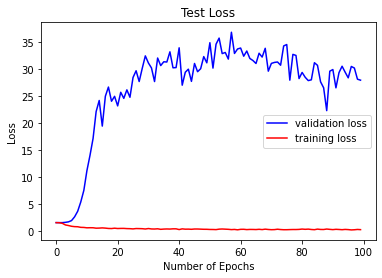

In [27]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="training loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

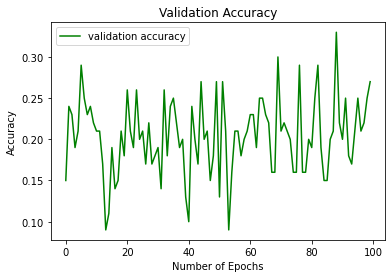

In [28]:
# Plot the accuracy curve for validation 
plt.plot(history.history['val_accuracy'], color='g', label="validation accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
classifier.save('cnn_weights_2.h5')

In [30]:
classifier.load_weights('cnn_weights_2.h5')

In [31]:
model_feat = Model(inputs=classifier.input,outputs=classifier.get_layer('dense_1').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

(36000, 5)
(9000, 5)


In [32]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
start = time.time() # Measuring the processing time
svm.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)
print('fitting done !!!')

2.6647489070892334
fitting done !!!


In [33]:
svm.score(feat_train,np.argmax(y_train,axis=1))

0.9613333333333334

In [34]:
svm.score(feat_test,np.argmax(y_test,axis=1))

0.9634444444444444

In [35]:
Pred_labels = svm.predict(feat_test)

# Applying XGBOOST

In [36]:
import xgboost as xgb

xb = xgb.XGBClassifier()
start = time.time() # Measuring the processing time
xb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start)
print('fitting done !!!')

5.589130401611328
fitting done !!!


In [37]:
Pred_labels = xb.predict(feat_test)

In [38]:
import seaborn as sns

In [39]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['Arborio', 'Basmati','Ipsala','Jasmine','Karacadag'])
    df_cm2.columns=['Arborio', 'Basmati','Ipsala','Jasmine','Karacadag']
    f,ax = plt.subplots(figsize=(12, 12))
    #ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()    
    return

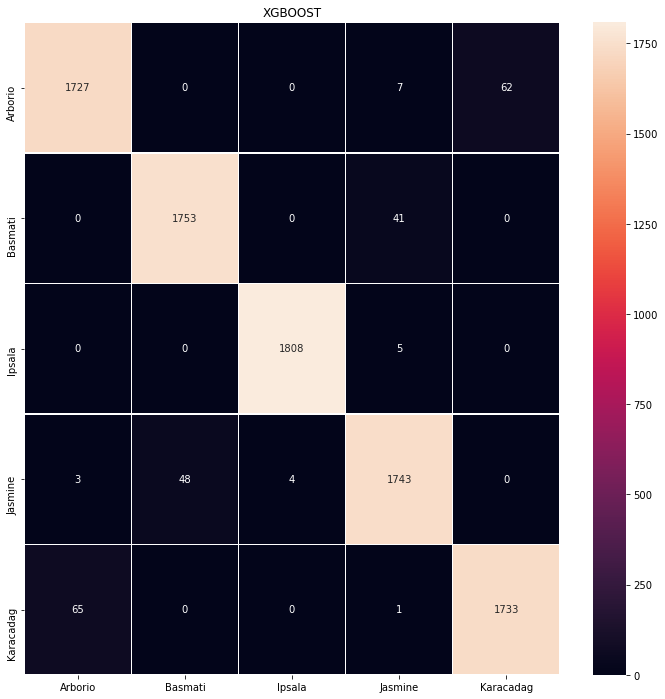

In [40]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'XGBOOST')

In [41]:
from sklearn.metrics import classification_report
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9621    0.9616    0.9618      1796
           1     0.9733    0.9771    0.9752      1794
           2     0.9978    0.9972    0.9975      1813
           3     0.9699    0.9694    0.9697      1798
           4     0.9655    0.9633    0.9644      1799

    accuracy                         0.9738      9000
   macro avg     0.9737    0.9737    0.9737      9000
weighted avg     0.9738    0.9738    0.9738      9000



In [42]:
Pred_labels = svm.predict(feat_test)

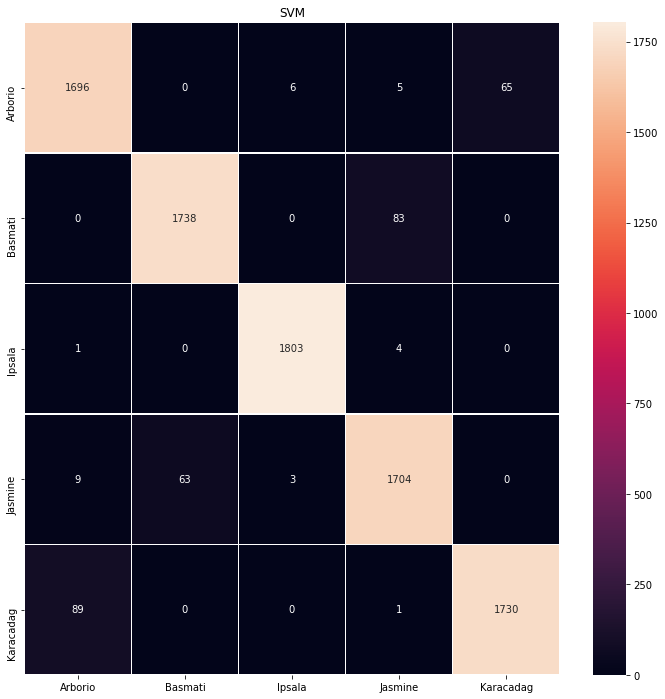

In [43]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'SVM')

In [44]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1),digits=4))

              precision    recall  f1-score   support

           0     0.9448    0.9571    0.9509      1772
           1     0.9650    0.9544    0.9597      1821
           2     0.9950    0.9972    0.9961      1808
           3     0.9482    0.9578    0.9530      1779
           4     0.9638    0.9505    0.9571      1820

    accuracy                         0.9634      9000
   macro avg     0.9634    0.9634    0.9634      9000
weighted avg     0.9635    0.9634    0.9635      9000



In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [47]:
lr = LogisticRegression()
start = time.time() # Measuring the processing time
lr.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print('fitting done !!!')

fitting done !!!


In [48]:
print(end - start) # Total 

1.737351655960083


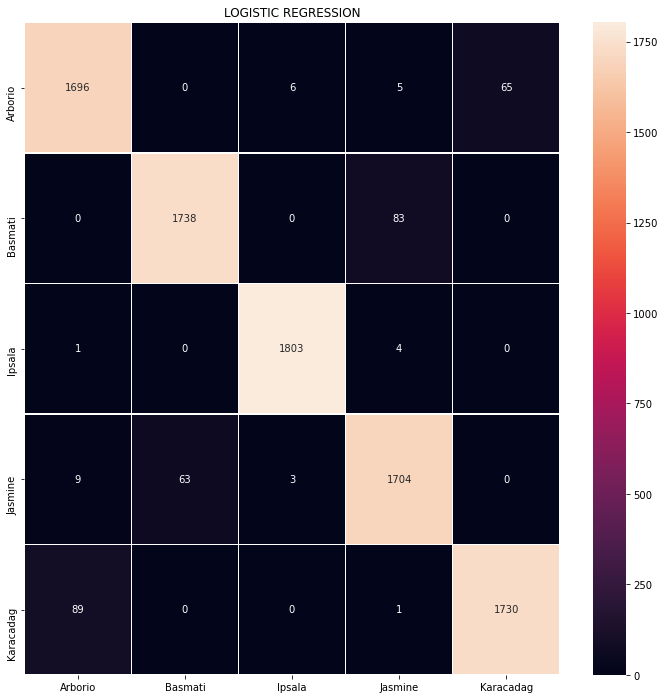

In [49]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LOGISTIC REGRESSION')

In [50]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

              precision    recall  f1-score   support

           0     0.9465    0.9465    0.9465      1795
           1     0.9706    0.9464    0.9583      1847
           2     0.9945    0.9967    0.9956      1808
           3     0.9360    0.9633    0.9495      1746
           4     0.9565    0.9518    0.9542      1804

    accuracy                         0.9609      9000
   macro avg     0.9608    0.9609    0.9608      9000
weighted avg     0.9611    0.9609    0.9609      9000



In [51]:
dt = DecisionTreeClassifier()
start = time.time() # Measuring the processing time
dt.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.4115746021270752
fitting done !!!
              precision    recall  f1-score   support

           0     0.9404    0.9352    0.9378      1805
           1     0.9617    0.9644    0.9630      1796
           2     0.9967    0.9956    0.9961      1814
           3     0.9544    0.9570    0.9557      1792
           4     0.9409    0.9420    0.9415      1793

    accuracy                         0.9589      9000
   macro avg     0.9588    0.9588    0.9588      9000
weighted avg     0.9589    0.9589    0.9589      9000



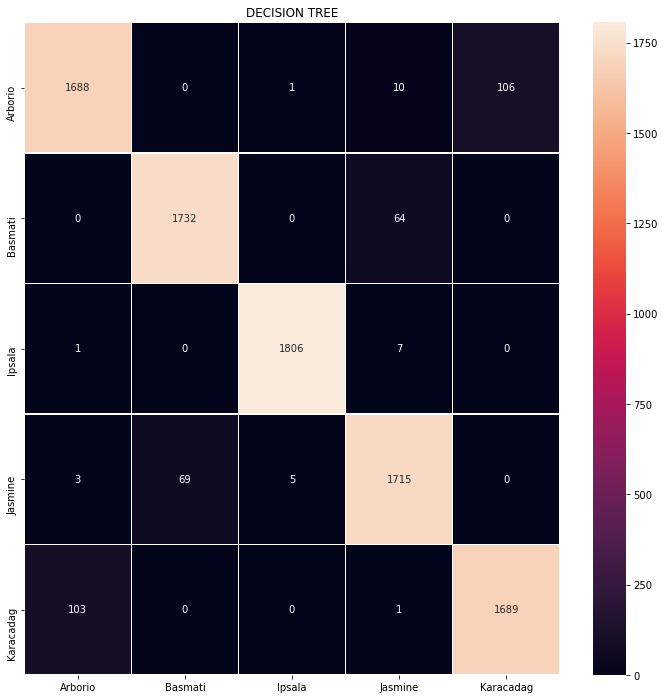

In [52]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'DECISION TREE')

In [53]:
knn = KNeighborsClassifier()
start = time.time() # Measuring the processing time
knn.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

0.1623368263244629
fitting done !!!
              precision    recall  f1-score   support

           0     0.9476    0.9535    0.9505      1784
           1     0.9672    0.9577    0.9624      1819
           2     0.9950    0.9972    0.9961      1808
           3     0.9494    0.9611    0.9552      1775
           4     0.9616    0.9515    0.9565      1814

    accuracy                         0.9642      9000
   macro avg     0.9642    0.9642    0.9642      9000
weighted avg     0.9643    0.9642    0.9642      9000



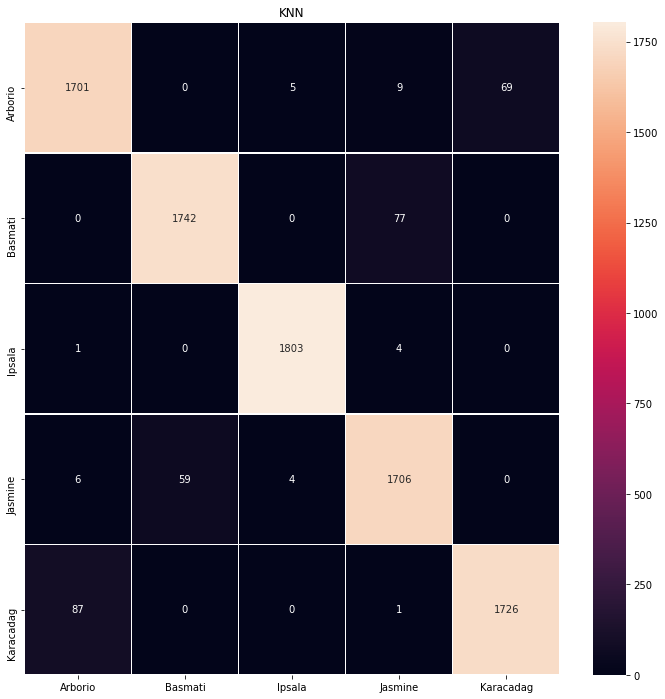

In [54]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'KNN')

In [55]:
lda = LinearDiscriminantAnalysis()
start = time.time() # Measuring the processing time
lda.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.2565298080444336
fitting done !!!
              precision    recall  f1-score   support

           0     0.9376    0.9541    0.9458      1764
           1     0.9817    0.9359    0.9583      1889
           2     0.9934    0.9961    0.9947      1807
           3     0.9232    0.9747    0.9483      1702
           4     0.9666    0.9440    0.9551      1838

    accuracy                         0.9606      9000
   macro avg     0.9605    0.9610    0.9604      9000
weighted avg     0.9612    0.9606    0.9606      9000



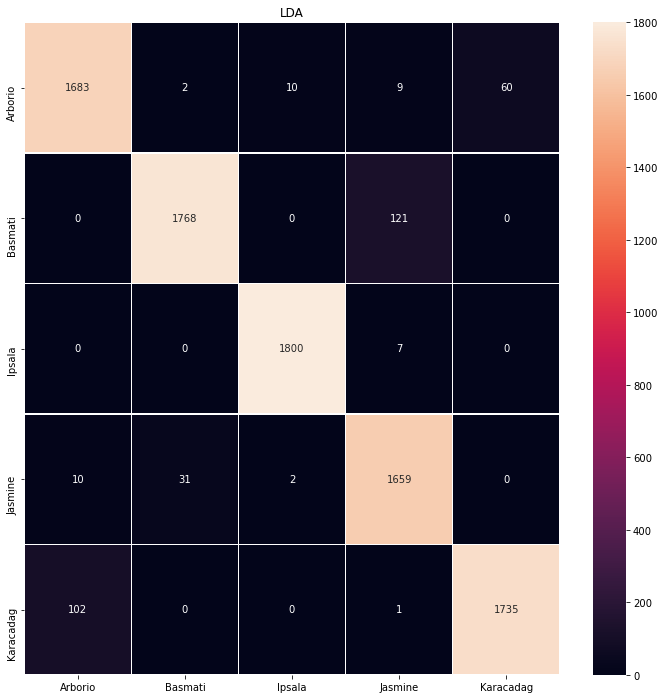

In [56]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'LDA')

In [57]:
nb = GaussianNB()
start = time.time() # Measuring the processing time
nb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total 

print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels,np.argmax(y_test,axis =1), digits=4))

0.011954069137573242
fitting done !!!
              precision    recall  f1-score   support

           0     0.9103    0.9773    0.9426      1672
           1     0.9845    0.9615    0.9728      1844
           2     0.9923    0.9978    0.9950      1802
           3     0.9538    0.9755    0.9645      1757
           4     0.9855    0.9190    0.9511      1925

    accuracy                         0.9653      9000
   macro avg     0.9653    0.9662    0.9652      9000
weighted avg     0.9665    0.9653    0.9654      9000



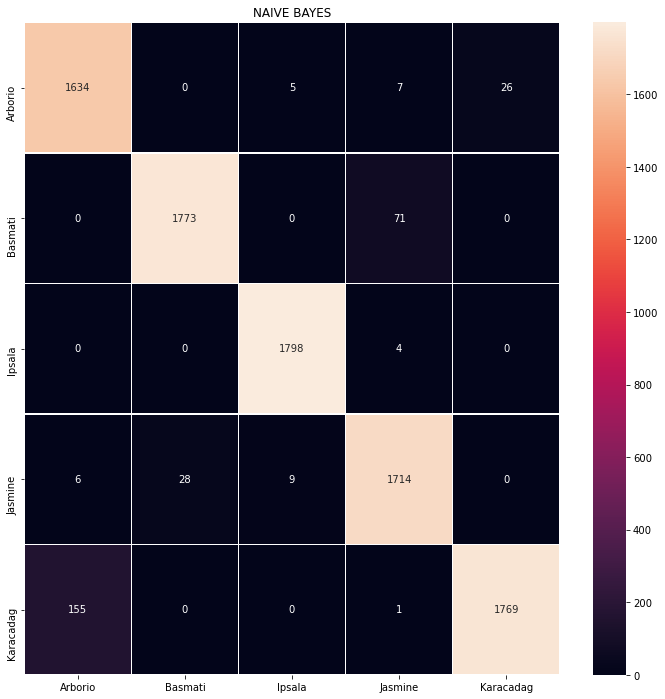

In [58]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'NAIVE BAYES')

In [59]:
et = ExtraTreesClassifier()
start = time.time() # Measuring the processing time
et.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

1.8781421184539795
fitting done !!!
              precision    recall  f1-score   support

           0     0.9526    0.9537    0.9532      1793
           1     0.9689    0.9743    0.9716      1791
           2     0.9967    0.9972    0.9970      1811
           3     0.9661    0.9644    0.9652      1800
           4     0.9610    0.9557    0.9583      1805

    accuracy                         0.9691      9000
   macro avg     0.9691    0.9691    0.9691      9000
weighted avg     0.9691    0.9691    0.9691      9000



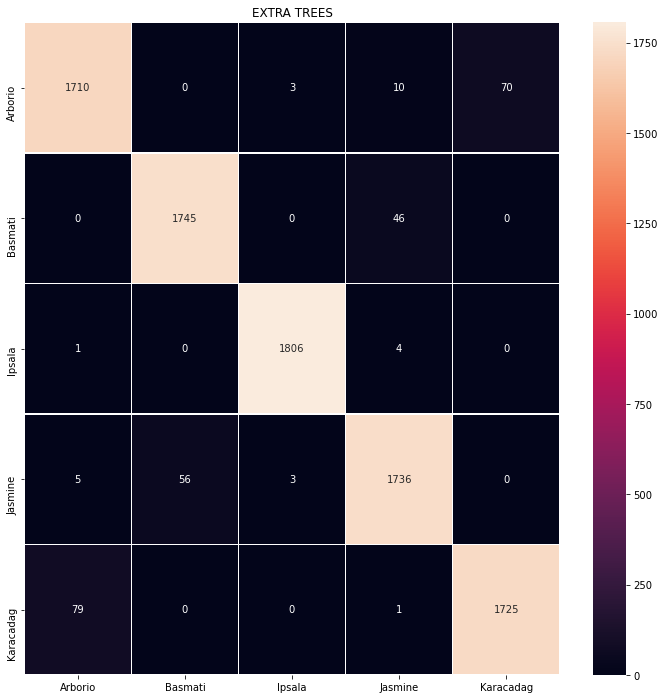

In [60]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'EXTRA TREES')

In [61]:
rf = RandomForestClassifier()
start = time.time() # Measuring the processing time
rf.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

6.444183111190796
fitting done !!!
              precision    recall  f1-score   support

           0     0.9526    0.9537    0.9532      1793
           1     0.9689    0.9743    0.9716      1791
           2     0.9967    0.9972    0.9970      1811
           3     0.9661    0.9644    0.9652      1800
           4     0.9610    0.9557    0.9583      1805

    accuracy                         0.9691      9000
   macro avg     0.9691    0.9691    0.9691      9000
weighted avg     0.9691    0.9691    0.9691      9000



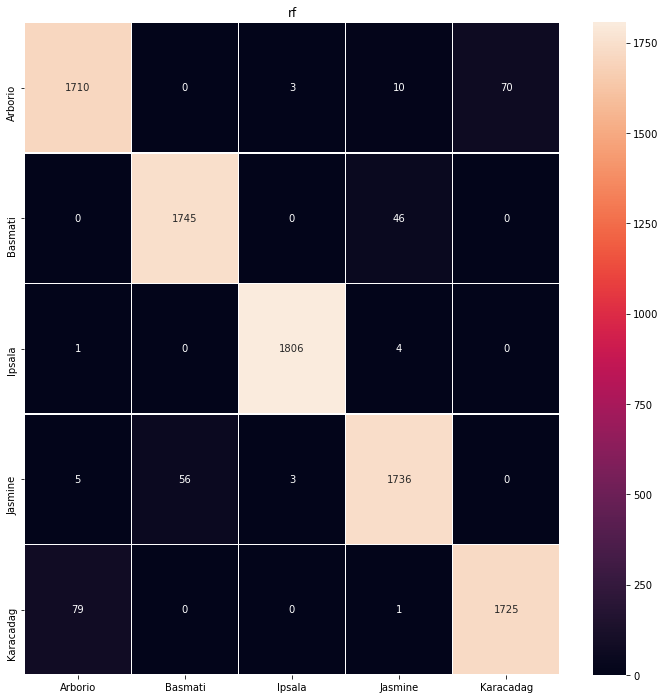

In [62]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'rf')

In [63]:
import lightgbm as lgb

In [64]:
lg = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
start = time.time() # Measuring the processing time
lg.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

1.0839478969573975
fitting done !!!
              precision    recall  f1-score   support

           0     0.9526    0.9537    0.9532      1793
           1     0.9689    0.9743    0.9716      1791
           2     0.9967    0.9972    0.9970      1811
           3     0.9661    0.9644    0.9652      1800
           4     0.9610    0.9557    0.9583      1805

    accuracy                         0.9691      9000
   macro avg     0.9691    0.9691    0.9691      9000
weighted avg     0.9691    0.9691    0.9691      9000



In [65]:
from catboost import CatBoostClassifier

In [66]:
cb = CatBoostClassifier()
start = time.time() # Measuring the processing time
cb.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

Learning rate set to 0.094994
0:	learn: 1.2801219	total: 368ms	remaining: 6m 7s
1:	learn: 1.0727786	total: 385ms	remaining: 3m 12s
2:	learn: 0.9213181	total: 404ms	remaining: 2m 14s
3:	learn: 0.8030284	total: 425ms	remaining: 1m 45s
4:	learn: 0.7085025	total: 453ms	remaining: 1m 30s
5:	learn: 0.6315555	total: 478ms	remaining: 1m 19s
6:	learn: 0.5666264	total: 497ms	remaining: 1m 10s
7:	learn: 0.5114031	total: 515ms	remaining: 1m 3s
8:	learn: 0.4646363	total: 534ms	remaining: 58.8s
9:	learn: 0.4232671	total: 552ms	remaining: 54.7s
10:	learn: 0.3880975	total: 573ms	remaining: 51.5s
11:	learn: 0.3564420	total: 592ms	remaining: 48.7s
12:	learn: 0.3278443	total: 610ms	remaining: 46.3s
13:	learn: 0.3028155	total: 628ms	remaining: 44.3s
14:	learn: 0.2809937	total: 647ms	remaining: 42.5s
15:	learn: 0.2621731	total: 665ms	remaining: 40.9s
16:	learn: 0.2445625	total: 684ms	remaining: 39.5s
17:	learn: 0.2292279	total: 702ms	remaining: 38.3s
18:	learn: 0.2152300	total: 720ms	remaining: 37.2s
19:	l

164:	learn: 0.0721490	total: 3.84s	remaining: 19.4s
165:	learn: 0.0721251	total: 3.88s	remaining: 19.5s
166:	learn: 0.0720834	total: 3.91s	remaining: 19.5s
167:	learn: 0.0720524	total: 3.94s	remaining: 19.5s
168:	learn: 0.0720204	total: 3.97s	remaining: 19.5s
169:	learn: 0.0719845	total: 4s	remaining: 19.6s
170:	learn: 0.0719461	total: 4.03s	remaining: 19.6s
171:	learn: 0.0719179	total: 4.05s	remaining: 19.5s
172:	learn: 0.0718808	total: 4.07s	remaining: 19.5s
173:	learn: 0.0718256	total: 4.09s	remaining: 19.4s
174:	learn: 0.0717956	total: 4.11s	remaining: 19.4s
175:	learn: 0.0717354	total: 4.13s	remaining: 19.3s
176:	learn: 0.0716968	total: 4.15s	remaining: 19.3s
177:	learn: 0.0716465	total: 4.17s	remaining: 19.3s
178:	learn: 0.0716223	total: 4.19s	remaining: 19.2s
179:	learn: 0.0715954	total: 4.21s	remaining: 19.2s
180:	learn: 0.0715576	total: 4.23s	remaining: 19.1s
181:	learn: 0.0715024	total: 4.25s	remaining: 19.1s
182:	learn: 0.0714542	total: 4.28s	remaining: 19.1s
183:	learn: 0.0

328:	learn: 0.0668382	total: 7.23s	remaining: 14.7s
329:	learn: 0.0668187	total: 7.25s	remaining: 14.7s
330:	learn: 0.0667880	total: 7.27s	remaining: 14.7s
331:	learn: 0.0667609	total: 7.29s	remaining: 14.7s
332:	learn: 0.0667348	total: 7.31s	remaining: 14.6s
333:	learn: 0.0667173	total: 7.33s	remaining: 14.6s
334:	learn: 0.0667048	total: 7.35s	remaining: 14.6s
335:	learn: 0.0666767	total: 7.37s	remaining: 14.6s
336:	learn: 0.0666498	total: 7.38s	remaining: 14.5s
337:	learn: 0.0666351	total: 7.41s	remaining: 14.5s
338:	learn: 0.0666019	total: 7.42s	remaining: 14.5s
339:	learn: 0.0665764	total: 7.45s	remaining: 14.5s
340:	learn: 0.0665557	total: 7.47s	remaining: 14.4s
341:	learn: 0.0665353	total: 7.49s	remaining: 14.4s
342:	learn: 0.0664886	total: 7.52s	remaining: 14.4s
343:	learn: 0.0664718	total: 7.54s	remaining: 14.4s
344:	learn: 0.0664485	total: 7.57s	remaining: 14.4s
345:	learn: 0.0664381	total: 7.59s	remaining: 14.4s
346:	learn: 0.0664183	total: 7.62s	remaining: 14.3s
347:	learn: 

487:	learn: 0.0632250	total: 10.6s	remaining: 11.1s
488:	learn: 0.0632068	total: 10.6s	remaining: 11.1s
489:	learn: 0.0631868	total: 10.7s	remaining: 11.1s
490:	learn: 0.0631776	total: 10.7s	remaining: 11.1s
491:	learn: 0.0631581	total: 10.7s	remaining: 11.1s
492:	learn: 0.0631323	total: 10.7s	remaining: 11.1s
493:	learn: 0.0630994	total: 10.8s	remaining: 11s
494:	learn: 0.0630839	total: 10.8s	remaining: 11s
495:	learn: 0.0630616	total: 10.8s	remaining: 11s
496:	learn: 0.0630453	total: 10.8s	remaining: 11s
497:	learn: 0.0630266	total: 10.9s	remaining: 10.9s
498:	learn: 0.0630047	total: 10.9s	remaining: 10.9s
499:	learn: 0.0629807	total: 10.9s	remaining: 10.9s
500:	learn: 0.0629566	total: 10.9s	remaining: 10.9s
501:	learn: 0.0629266	total: 11s	remaining: 10.9s
502:	learn: 0.0629091	total: 11s	remaining: 10.8s
503:	learn: 0.0628916	total: 11s	remaining: 10.8s
504:	learn: 0.0628822	total: 11s	remaining: 10.8s
505:	learn: 0.0628623	total: 11.1s	remaining: 10.8s
506:	learn: 0.0628191	total:

646:	learn: 0.0601513	total: 14s	remaining: 7.62s
647:	learn: 0.0601421	total: 14s	remaining: 7.6s
648:	learn: 0.0601180	total: 14s	remaining: 7.58s
649:	learn: 0.0600971	total: 14s	remaining: 7.55s
650:	learn: 0.0600813	total: 14s	remaining: 7.53s
651:	learn: 0.0600684	total: 14.1s	remaining: 7.51s
652:	learn: 0.0600518	total: 14.1s	remaining: 7.48s
653:	learn: 0.0600318	total: 14.1s	remaining: 7.46s
654:	learn: 0.0600145	total: 14.1s	remaining: 7.44s
655:	learn: 0.0599795	total: 14.1s	remaining: 7.42s
656:	learn: 0.0599725	total: 14.2s	remaining: 7.39s
657:	learn: 0.0599518	total: 14.2s	remaining: 7.38s
658:	learn: 0.0599344	total: 14.2s	remaining: 7.36s
659:	learn: 0.0599274	total: 14.2s	remaining: 7.34s
660:	learn: 0.0599037	total: 14.3s	remaining: 7.32s
661:	learn: 0.0598899	total: 14.3s	remaining: 7.3s
662:	learn: 0.0598739	total: 14.3s	remaining: 7.28s
663:	learn: 0.0598593	total: 14.3s	remaining: 7.26s
664:	learn: 0.0598367	total: 14.4s	remaining: 7.24s
665:	learn: 0.0598260	to

806:	learn: 0.0573612	total: 17.1s	remaining: 4.1s
807:	learn: 0.0573376	total: 17.2s	remaining: 4.08s
808:	learn: 0.0573141	total: 17.2s	remaining: 4.06s
809:	learn: 0.0572911	total: 17.2s	remaining: 4.04s
810:	learn: 0.0572755	total: 17.2s	remaining: 4.01s
811:	learn: 0.0572647	total: 17.2s	remaining: 3.99s
812:	learn: 0.0572519	total: 17.3s	remaining: 3.97s
813:	learn: 0.0572389	total: 17.3s	remaining: 3.95s
814:	learn: 0.0572317	total: 17.3s	remaining: 3.92s
815:	learn: 0.0572159	total: 17.3s	remaining: 3.9s
816:	learn: 0.0571958	total: 17.3s	remaining: 3.88s
817:	learn: 0.0571825	total: 17.4s	remaining: 3.86s
818:	learn: 0.0571668	total: 17.4s	remaining: 3.84s
819:	learn: 0.0571606	total: 17.4s	remaining: 3.82s
820:	learn: 0.0571496	total: 17.4s	remaining: 3.79s
821:	learn: 0.0571411	total: 17.4s	remaining: 3.77s
822:	learn: 0.0571344	total: 17.4s	remaining: 3.75s
823:	learn: 0.0571239	total: 17.5s	remaining: 3.73s
824:	learn: 0.0571134	total: 17.5s	remaining: 3.71s
825:	learn: 0.

971:	learn: 0.0548252	total: 20.2s	remaining: 583ms
972:	learn: 0.0548169	total: 20.2s	remaining: 562ms
973:	learn: 0.0548087	total: 20.3s	remaining: 541ms
974:	learn: 0.0547850	total: 20.3s	remaining: 520ms
975:	learn: 0.0547763	total: 20.3s	remaining: 499ms
976:	learn: 0.0547632	total: 20.3s	remaining: 478ms
977:	learn: 0.0547448	total: 20.3s	remaining: 457ms
978:	learn: 0.0547339	total: 20.4s	remaining: 437ms
979:	learn: 0.0547138	total: 20.4s	remaining: 416ms
980:	learn: 0.0546950	total: 20.4s	remaining: 395ms
981:	learn: 0.0546875	total: 20.4s	remaining: 374ms
982:	learn: 0.0546748	total: 20.4s	remaining: 353ms
983:	learn: 0.0546617	total: 20.4s	remaining: 332ms
984:	learn: 0.0546482	total: 20.5s	remaining: 312ms
985:	learn: 0.0546331	total: 20.5s	remaining: 291ms
986:	learn: 0.0546189	total: 20.5s	remaining: 270ms
987:	learn: 0.0546024	total: 20.5s	remaining: 249ms
988:	learn: 0.0545909	total: 20.5s	remaining: 228ms
989:	learn: 0.0545773	total: 20.6s	remaining: 208ms
990:	learn: 

In [67]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [68]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
start = time.time() # Measuring the processing time
ensemble.fit(feat_train,np.argmax(y_train,axis=1))
end = time.time()
print(end - start) # Total

print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1), digits=4))

13.660071611404419
fitting done !!!
              precision    recall  f1-score   support

           0     0.9465    0.9664    0.9564      1758
           1     0.9828    0.9651    0.9739      1834
           2     0.9950    0.9978    0.9964      1807
           3     0.9588    0.9773    0.9680      1763
           4     0.9727    0.9499    0.9612      1838

    accuracy                         0.9712      9000
   macro avg     0.9712    0.9713    0.9712      9000
weighted avg     0.9714    0.9712    0.9712      9000



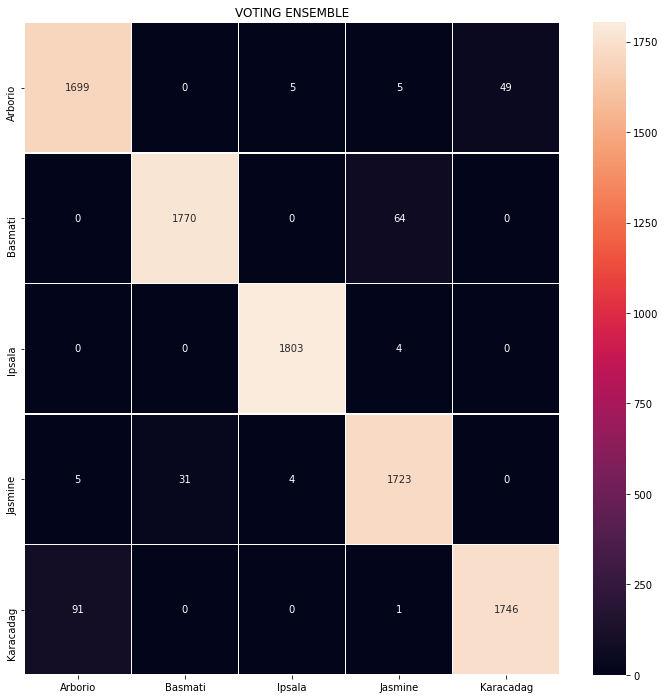

In [69]:
plot_heatmap(confusion_matrix(Pred_labels, np.argmax(y_test,axis =1)),'VOTING ENSEMBLE')